In [1]:
from utils import *
sns.set(style="darkgrid")

In [2]:
set_seed(0)

Random seed set as 0


In [3]:
df_h = Table.read('./table-4LAC-DR3-h.fits') 
df_h = df_h.to_pandas()
df_h = df_h[df_h['Flags']==0]

df_l = Table.read('./table-4LAC-DR3-l.fits') 
df_l = df_l.to_pandas()
df_l = df_l[df_l['Flags']==0]

classification_df = pd.concat([df_h, df_l], ignore_index=True)
classification_df['CLASS'] = classification_df['CLASS'].str.decode('utf-8')
classification_df['CLASS'] = classification_df['CLASS'].str.upper()
classification_df = classification_df[classification_df['CLASS'].isin(['BLL', 'FSRQ', 'BCU'])]

selected_columns = ['PL_Index', 'nu_syn', 'LP_Index', 'Pivot_Energy', 'Frac_Variability', 'Variability_Index', 'nuFnu_syn', 'CLASS']
target = 'CLASS'
feature_columns = [ele for ele in selected_columns if ele is not 'CLASS']


classification_df = classification_df[selected_columns]

classification_df

,PL_Index,nu_syn,LP_Index,Pivot_Energy,Frac_Variability,Variability_Index,nuFnu_syn,CLASS
0,2.271696,1.000000e+14,2.254081,2420.575195,0.675882,25.313953,3.716456e-13,BCU
1,2.116692,9.120108e+13,2.078927,1721.603882,0.406565,46.780693,1.936770e-12,BLL
2,1.939160,3.609939e+12,1.661223,4307.082520,0.000000,9.272764,2.473256e-13,BLL
3,2.654060,1.584893e+14,2.514159,329.773743,0.996138,1910.935791,1.152471e-12,FSRQ
4,1.876663,1.659588e+13,1.716620,4429.934082,0.902851,24.557972,9.716011e-13,BCU
...,...,...,...,...,...,...,...,...
3169,2.071567,3.311315e+13,2.042366,5897.854004,0.328630,14.602383,1.006315e-12,BCU
3170,2.226648,0.000000e+00,1.962429,3114.226318,1.071415,34.235767,0.000000e+00,BCU
3171,2.045913,0.000000e+00,2.019132,5066.525391,0.337927,22.359163,0.000000e+00,BCU
3172,1.810977,1.566751e+16,1.736923,1910.885742,0.201833,58.688427,1.279994e-11,BLL


In [4]:
def plot_column_distribution(column = None, df = None, transformed = False):
    plt.hist(df[column], bins = 100)
    plt.ylabel('Frequency')
    plt.xlabel('Values')
    if transformed == False:
        plt.title(f'Distribution of {column}')
    else:
        plt.title(f'Distribution of {column} after transformation')
    plt.show()

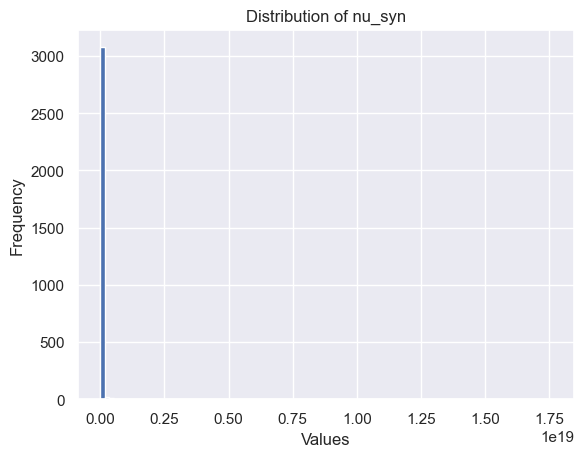

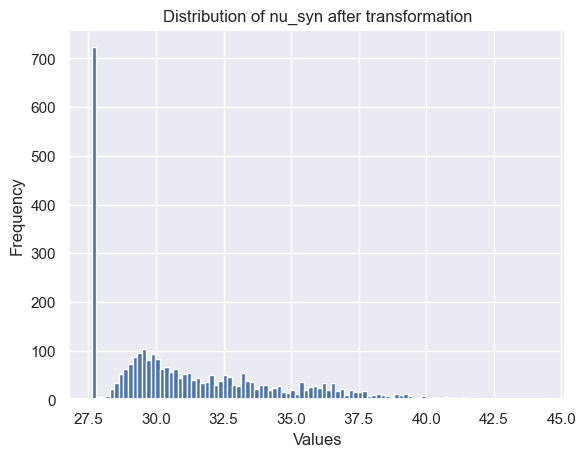

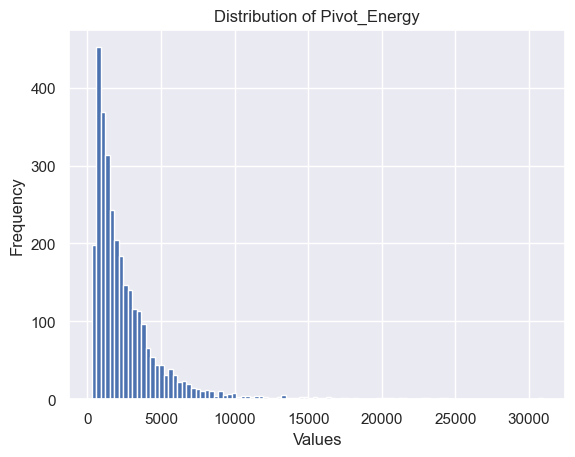

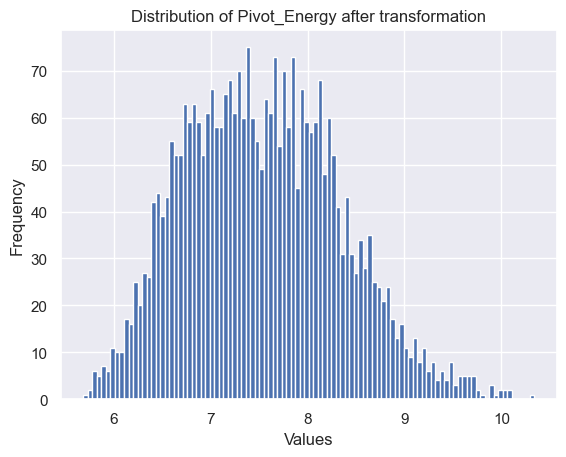

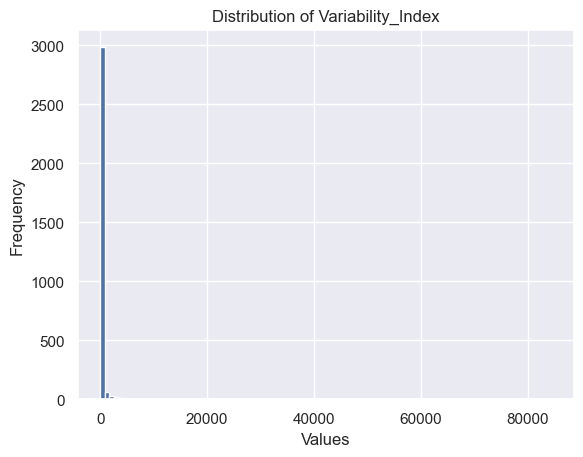

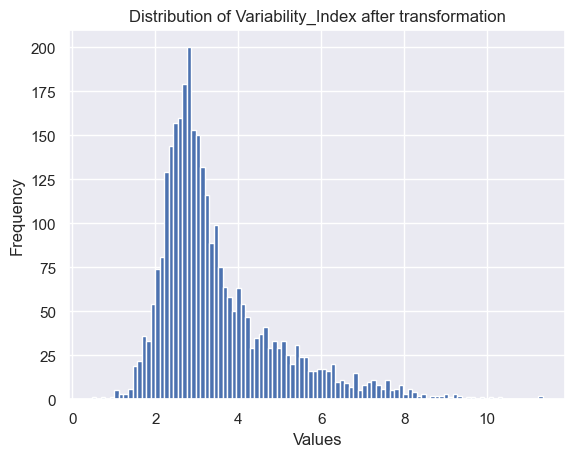

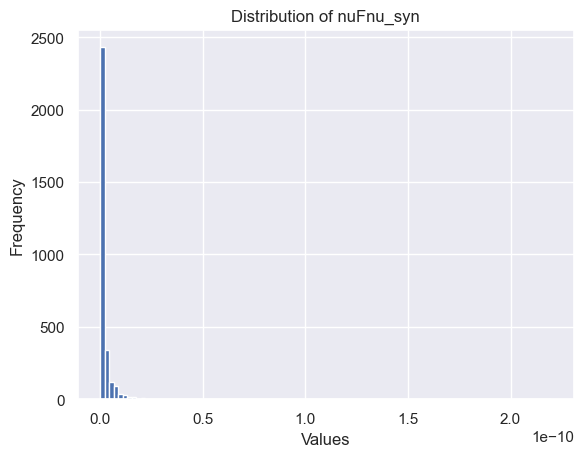

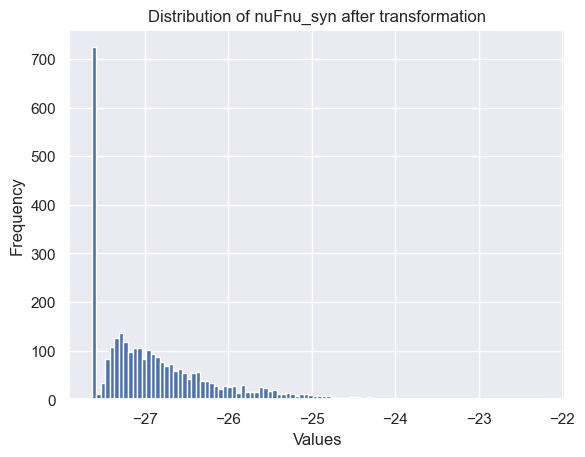

In [5]:
for column in feature_columns:
    if not(column in ["Frac_Variability", "GLAT", "GLON","LP_Index", "LP_beta", "PL_Index", "Unc_Flux1000","Unc_PL_Index"]):
        if column == 'nuFnu_syn':
            plot_column_distribution(column = column, df = classification_df, transformed=False)
            classification_df[column] = np.log(classification_df[column]+ 1e-12)
            plot_column_distribution(column = column, df = classification_df, transformed=True)
        elif column == 'nu_syn':
            plot_column_distribution(column = column, df = classification_df, transformed=False)
            classification_df[column] = np.log(classification_df[column] + 1e12)
            plot_column_distribution(column = column, df = classification_df, transformed=True)
        else: 
            plot_column_distribution(column = column, df = classification_df, transformed=False)
            classification_df[column] = np.log(classification_df[column])
            plot_column_distribution(column = column, df = classification_df, transformed=True)


In [6]:
bcu_samples = classification_df[classification_df['CLASS'].isin(['BCU'])]
classification_df = classification_df[~classification_df['CLASS'].isin(['BCU'])]

print(classification_df.shape)
print(bcu_samples.shape)

(2005, 8)
(1115, 8)


In [7]:
class_mapping = {'BLL': 0, 'FSRQ': 1}
classification_df['CLASS'] = classification_df['CLASS'].map(class_mapping)

In [8]:
transformer = make_column_transformer(
    (StandardScaler(), 
        feature_columns)
)

In [9]:
features = classification_df.drop([target], axis=1)
labels = classification_df[target]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [11]:
X_train.to_csv('./classification_data/train_samples.csv', index=False)
X_val.to_csv('./classification_data/val_samples.csv', index = False)
X_test.to_csv('./classification_data/test_samples.csv', index = False)
y_train.to_csv('./classification_data/train_labels.csv', index = False)
y_test.to_csv('./classification_data/test_labels.csv', index = False)
y_val.to_csv('./classification_data/val_labels.csv', index = False)
bcu_samples.to_csv('./classification_data/bcu_samples.csv', index = False)

In [12]:
transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_val = transformer.transform(X_val)
bcu_samples = transformer.transform(bcu_samples)

In [13]:
np.save('./classification_data/X_train.npy', X_train)
np.save('./classification_data/X_val.npy', X_val)
np.save('./classification_data/X_test.npy', X_test)
np.save('./classification_data/y_train.npy', y_train)
np.save('./classification_data/y_val.npy', y_val)
np.save('./classification_data/y_test.npy', y_test)
np.save('./classification_data/bcu_samples.npy', bcu_samples)

In [3]:
X_train = np.load('./classification_data/X_train.npy')
X_val = np.load('./classification_data/X_val.npy')
X_test = np.load('./classification_data/X_test.npy')
y_train = np.load('./classification_data/y_train.npy')
y_val = np.load('./classification_data/y_val.npy')
y_test = np.load('./classification_data/y_test.npy')
bcu_samples = np.load('./classification_data/bcu_samples.npy')

In [4]:
bll, fsrq = np.bincount(y_train)
print(bll)
print(fsrq)

1053
551


In [5]:
np.log([fsrq/bll])

array([-0.6476637])

In [6]:
from sklearn.utils.class_weight import compute_class_weight

cw = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y = y_train)
cw = {0:cw[0], 1:cw[1]}
cw

{0: 0.761633428300095, 1: 1.455535390199637}

In [7]:
output_bias = tf.keras.initializers.Constant(np.log([fsrq/bll]))
standard_nn_classifier = tf.keras.models.Sequential([
            tf.keras.layers.Dense(42, activation='relu', input_shape = (X_train.shape[1],)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer = output_bias)
        ])
standard_nn_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                336       
_________________________________________________________________
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 43        
Total params: 379
Trainable params: 379
Non-trainable params: 0
_________________________________________________________________


In [35]:
standard_nn_classifier_no_bias = tf.keras.models.Sequential([
            tf.keras.layers.Dense(42, activation='relu', input_shape = (X_train.shape[1],)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
import os
def train(model = None, mode = None, X_train= None, y_train= None, X_val = None, y_val = None, epochs = None):
    model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
    subdir = f'./checkpoints_{mode}/'
    os.makedirs(subdir, exist_ok=True)
    checkpoint_path = subdir + 'weights_epoch_{epoch:02d}.h5'
    ckpt = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=False,
        save_weights_only=True,
        mode='min',
        save_freq='epoch'
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 300
    )

    # Train the model
    model.fit(
        X_train,
        y_train, 
        epochs=epochs, 
        batch_size=2048, 
        verbose=1, 
        validation_data=(X_val, y_val), 
        callbacks = [PlotLossesKeras(), ckpt, early_stop]
    )

In [ ]:
train(
    model = standard_nn_classifier,
    mode = 'classifier_379_params',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs= 2500
)

In [82]:
import os
def train_with_cw(model = None, mode = None, X_train= None, y_train= None, X_val = None, y_val = None, epochs = None, cw = None):
    model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
    subdir = f'./checkpoints_{mode}/'
    os.makedirs(subdir, exist_ok=True)
    checkpoint_path = subdir + 'weights_epoch_{epoch:02d}.h5'
    ckpt = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=False,
        save_weights_only=True,
        mode='min',
        save_freq='epoch'
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 300
    )

    # Train the model
    model.fit(
        X_train,
        y_train, 
        epochs=epochs, 
        batch_size=2048, 
        verbose=1, 
        validation_data=(X_val, y_val), 
        callbacks = [PlotLossesKeras(), ckpt, early_stop],
        class_weight = cw
    )

100%|██████████| 504/504 [03:10<00:00,  2.65it/s]


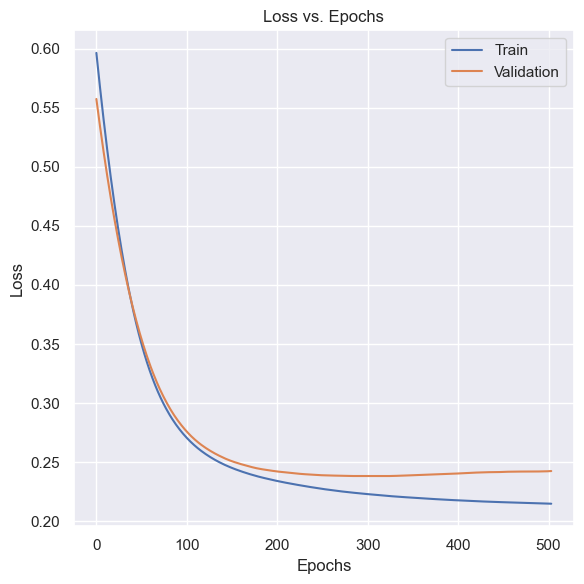

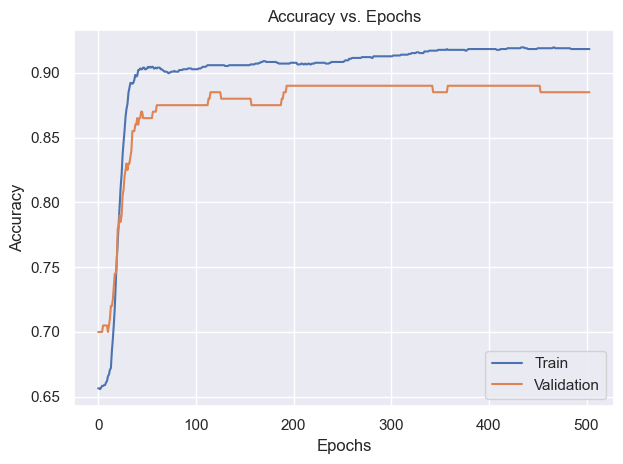

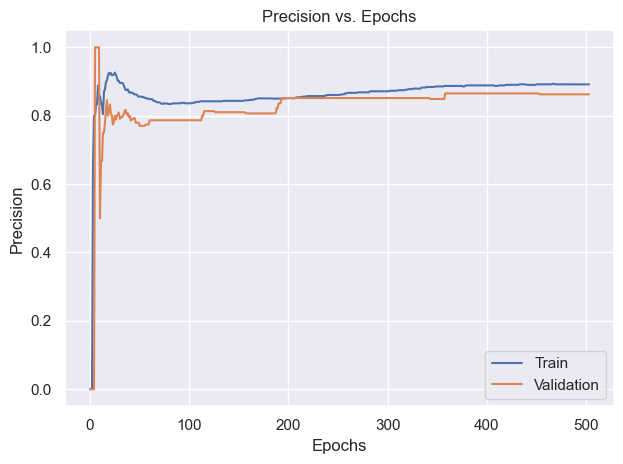

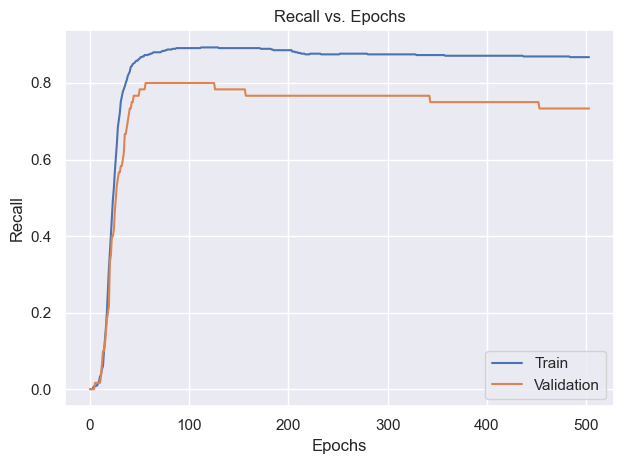

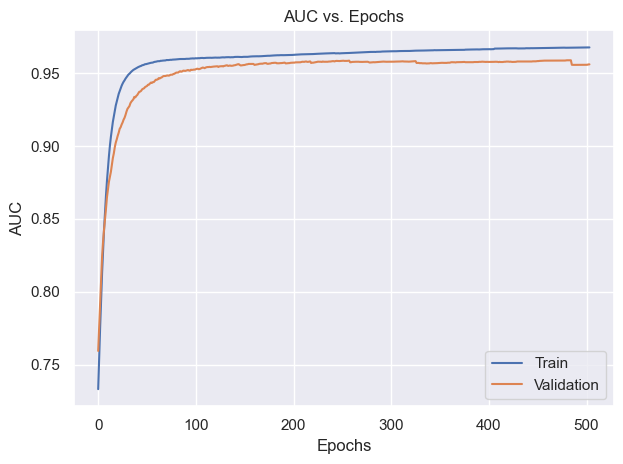

In [30]:
from tqdm import tqdm
metrics = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.AUC()
]
train_metric_results = []
val_metric_results = []
epochs = 504
standard_nn_classifier.compile(optimizer='adam', loss='binary_crossentropy',  metrics = metrics)
for epoch in tqdm(range(epochs)):
    model_path = f'./checkpoints_classifier_379_params/weights_epoch_{epoch+1:02d}.h5'
    standard_nn_classifier.load_weights(model_path)
    train_metrics = standard_nn_classifier.evaluate(X_train, y_train, verbose=0)
    val_metrics = standard_nn_classifier.evaluate(X_val, y_val, verbose=0)
    train_metric_results.append(train_metrics)
    val_metric_results.append(val_metrics)

train_metric_results = np.array(train_metric_results)
val_metric_results = np.array(val_metric_results)

metric_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC']
num_metrics = len(metrics)
plt.figure(figsize=(6, 6))

for i, metric_name in enumerate(metric_names):
    #plt.subplot(num_metrics, 1, i+1)
    plt.plot(range(epochs), train_metric_results[:, i], label='Train')
    plt.plot(range(epochs), val_metric_results[:, i], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} vs. Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()



In [7]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
best_auc = 0
best_accuracy = 0
best_f1 = 0
best_f1_0 = 0
best_f1_1 = 0
best_precision = 0
best_pr_0 = 0
best_pr_1 = 0
best_recall = 0
best_r0 = 0
best_r1 = 0
best_weights = {
    'auc': None, 
    'accuracy': None, 
    'f1':None, 
    'f1_0':None, 
    'f1_1':None,
    'precision': None,
    'r0': None,
    'r1': None,
    'pr_0':None,
    'pr_1':None,
    'recall': None
}

for epoch in tqdm(range(len(os.listdir('./checkpoints_classifier_379_params/')))):
    weights_path = f"./checkpoints_classifier_379_params/weights_epoch_{epoch+1:02d}.h5"
    standard_nn_classifier.load_weights(weights_path)
    
    # Evaluate the model
    predictions = standard_nn_classifier.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, np.round(predictions))
    f1_0 = f1_score(y_test, np.round(predictions), pos_label=0)
    f1_1 = f1_score(y_test, np.round(predictions), pos_label=1)
    f1 = f1_score(y_test, np.round(predictions), average='weighted')
    precision = precision_score(y_test, np.round(predictions), average='weighted')
    pr_0 = precision_score(y_test, np.round(predictions), pos_label=0)
    pr_1 = precision_score(y_test, np.round(predictions), pos_label=1)
    recall = recall_score(y_test, np.round(predictions), average='weighted')
    r0 = recall_score(y_test, np.round(predictions), pos_label=0)
    r1 = recall_score(y_test, np.round(predictions), pos_label=1)
    
    #accuracy = standard_nn_classifier.evaluate(X_test, y_test, verbose=0)[1]
    
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_weights['auc'] = weights_path
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights['accuracy'] = weights_path
    if f1 > best_f1:
        best_f1 = f1
        best_weights['f1'] = weights_path
    if f1_0 > best_f1_0:
        best_f1_0 = f1_0
        best_weights['f1_0'] = weights_path
    if f1_1 > best_f1_1:
        best_f1_1 = f1_1
        best_weights['f1_1'] = weights_path
    if precision > best_precision:
        best_precision = precision
        best_weights['precision'] = weights_path
    if pr_0 > best_pr_0:
        best_pr_0 = pr_0 
        best_weights['pr_0'] = weights_path
    if pr_1 > best_pr_1:
        best_pr_1 = pr_1 
        best_weights['pr_1'] = weights_path
    if r0 > best_r0:
        best_r0 = r0 
        best_weights['r0'] = weights_path
    if r1 > best_r1:
        best_r1 = r1 
        best_weights['r1'] = weights_path
    if recall > best_recall:
        best_recall = recall
        best_weights['recall'] = weights_path

print("Best ROC AUC:", round(best_auc,2))
print("Best accuracy:", round(best_accuracy,2))
print("Best PR(0):", round(best_pr_0,2))
print("Best R(0):", round(best_r0,2))
print("Best F1(0):", round(best_f1_0,2))
print("Best PR(1):", round(best_pr_1,2))
print("Best R(1):", round(best_r1,2))
print("Best F1(1):", round(best_f1_1,2))
print("Best F1:", round(best_f1,2))
print('Best precision:', round(best_precision,2))
print('Best recall:', round(best_recall,2))
print(best_weights)

  0%|          | 0/504 [00:00<?, ?it/s]

100%|██████████| 504/504 [00:29<00:00, 17.26it/s]

Best ROC AUC: 0.96
Best accuracy: 0.93
Best F1: 0.92
Best F1(0): 0.95
Best F1(1): 0.87
Best precision: 0.92
Best recall: 0.93
{'auc': './checkpoints_classifier_379_params/weights_epoch_277.h5', 'accuracy': './checkpoints_classifier_379_params/weights_epoch_40.h5', 'f1': './checkpoints_classifier_379_params/weights_epoch_41.h5', 'f1_0': './checkpoints_classifier_379_params/weights_epoch_40.h5', 'f1_1': './checkpoints_classifier_379_params/weights_epoch_41.h5', 'precision': './checkpoints_classifier_379_params/weights_epoch_40.h5', 'recall': './checkpoints_classifier_379_params/weights_epoch_40.h5'}


In [10]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
best_auc = 0
best_accuracy = 0
best_f1 = 0
best_f1_0 = 0
best_f1_1 = 0
best_precision = 0
best_pr_0 = 0
best_pr_1 = 0
best_recall = 0
best_r0 = 0
best_r1 = 0
best_weights = {
    'auc': None, 
    'accuracy': None, 
    'f1':None, 
    'f1_0':None, 
    'f1_1':None,
    'precision': None,
    'r0': None,
    'r1': None,
    'pr_0':None,
    'pr_1':None,
    'recall': None
}

for epoch in tqdm(range(len(os.listdir('./checkpoints_classifier_379_params/')))):
    weights_path = f"./checkpoints_classifier_379_params/weights_epoch_{epoch+1:02d}.h5"
    standard_nn_classifier.load_weights(weights_path)
    
    # Evaluate the model
    predictions = standard_nn_classifier.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, np.round(predictions))
    f1_0 = f1_score(y_test, np.round(predictions), pos_label=0)
    f1_1 = f1_score(y_test, np.round(predictions), pos_label=1)
    f1 = f1_score(y_test, np.round(predictions), average='weighted')
    precision = precision_score(y_test, np.round(predictions), average='weighted')
    pr_0 = precision_score(y_test, np.round(predictions), pos_label=0)
    pr_1 = precision_score(y_test, np.round(predictions), pos_label=1)
    recall = recall_score(y_test, np.round(predictions), average='weighted')
    r0 = recall_score(y_test, np.round(predictions), pos_label=0)
    r1 = recall_score(y_test, np.round(predictions), pos_label=1)
    
    #accuracy = standard_nn_classifier.evaluate(X_test, y_test, verbose=0)[1]
    
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_weights['auc'] = weights_path
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights['accuracy'] = weights_path
    if f1 > best_f1:
        best_f1 = f1
        best_weights['f1'] = weights_path
    if f1_0 > best_f1_0:
        best_f1_0 = f1_0
        best_weights['f1_0'] = weights_path
    if f1_1 > best_f1_1:
        best_f1_1 = f1_1
        best_weights['f1_1'] = weights_path
    if precision > best_precision:
        best_precision = precision
        best_weights['precision'] = weights_path
    if pr_0 > best_pr_0:
        best_pr_0 = pr_0 
        best_weights['pr_0'] = weights_path
    if pr_1 > best_pr_1:
        best_pr_1 = pr_1 
        best_weights['pr_1'] = weights_path
    if r0 > best_r0:
        best_r0 = r0 
        best_weights['r0'] = weights_path
    if r1 > best_r1:
        best_r1 = r1 
        best_weights['r1'] = weights_path
    if recall > best_recall:
        best_recall = recall
        best_weights['recall'] = weights_path

print("Best ROC AUC:", round(best_auc,2))
print("Best accuracy:", round(best_accuracy,2))
print("Best PR(0):", round(best_pr_0,2))
print("Best R(0):", round(best_r0,2))
print("Best F1(0):", round(best_f1_0,2))
print("Best PR(1):", round(best_pr_1,2))
print("Best R(1):", round(best_r1,2))
print("Best F1(1):", round(best_f1_1,2))
print("Best F1:", round(best_f1,2))
print('Best precision:', round(best_precision,2))
print('Best recall:', round(best_recall,2))
print(best_weights)

100%|██████████| 504/504 [00:30<00:00, 16.69it/s]

Best ROC AUC: 0.96
Best accuracy: 0.93
Best PR(0): 0.94
Best R(0): 1.0
Best F1(0): 0.95
Best PR(1): 1.0
Best R(1): 0.86
Best F1(1): 0.87
Best F1: 0.92
Best precision: 0.92
Best recall: 0.93
{'auc': './checkpoints_classifier_379_params/weights_epoch_277.h5', 'accuracy': './checkpoints_classifier_379_params/weights_epoch_40.h5', 'f1': './checkpoints_classifier_379_params/weights_epoch_41.h5', 'f1_0': './checkpoints_classifier_379_params/weights_epoch_40.h5', 'f1_1': './checkpoints_classifier_379_params/weights_epoch_41.h5', 'precision': './checkpoints_classifier_379_params/weights_epoch_40.h5', 'r0': './checkpoints_classifier_379_params/weights_epoch_01.h5', 'r1': './checkpoints_classifier_379_params/weights_epoch_67.h5', 'pr_0': './checkpoints_classifier_379_params/weights_epoch_477.h5', 'pr_1': './checkpoints_classifier_379_params/weights_epoch_01.h5', 'recall': './checkpoints_classifier_379_params/weights_epoch_40.h5'}


In [67]:
preds = np.zeros((y_test.shape[0],1))
epochs = [40,41]
weights = [0.1,0.9]
for epoch, weight in zip(epochs, weights):
    if epoch == 1:
        epoch = '01'
    weights_path = f"./checkpoints_classifier_379_params/weights_epoch_{epoch}.h5"
    standard_nn_classifier.load_weights(weights_path)
    predictions = standard_nn_classifier.predict(X_test)
    preds+=weight*predictions

preds/=np.sum(weights)
print(roc_auc_score(y_test, preds))
print(classification_report(y_test, np.round(preds), digits = 3))


0.9493912628312247
              precision    recall  f1-score   support

           0      0.938     0.965     0.951       142
           1      0.909     0.847     0.877        59

    accuracy                          0.930       201
   macro avg      0.924     0.906     0.914       201
weighted avg      0.930     0.930     0.930       201



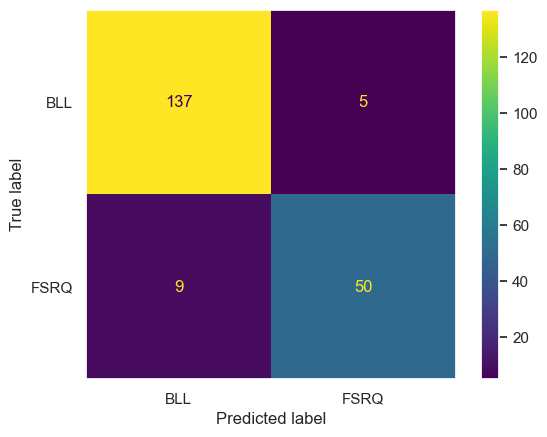

In [55]:
sns.set(style="dark")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, np.round(preds))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BLL', 'FSRQ'])
disp.plot()
plt.show()

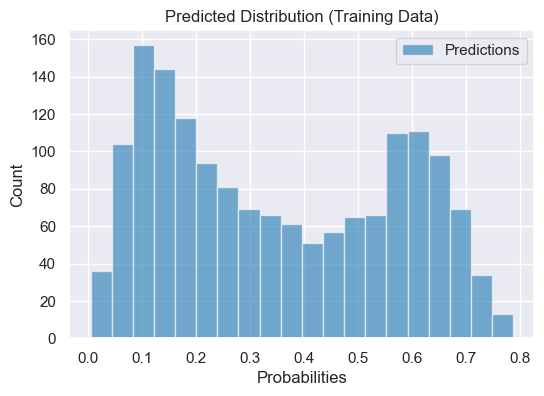

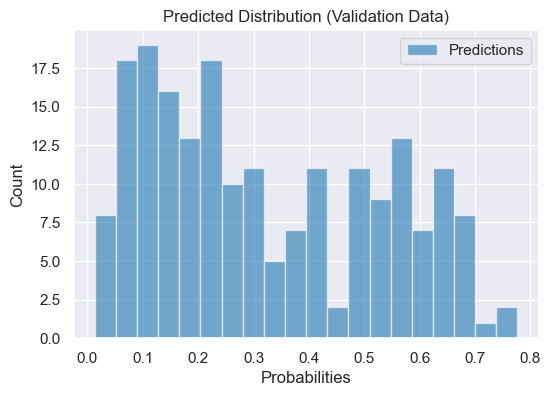

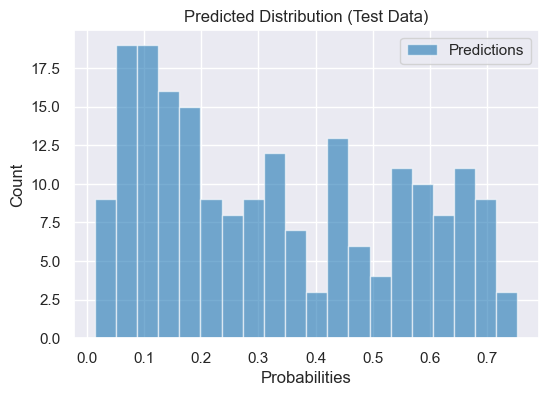

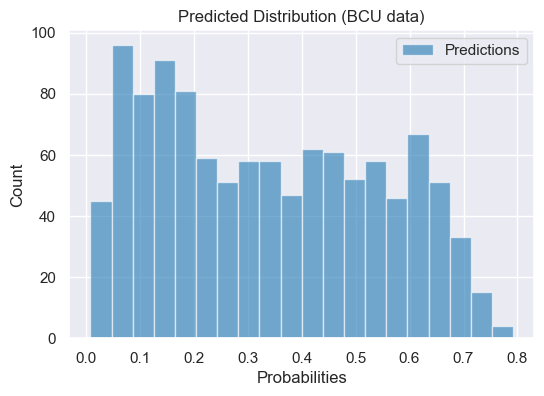

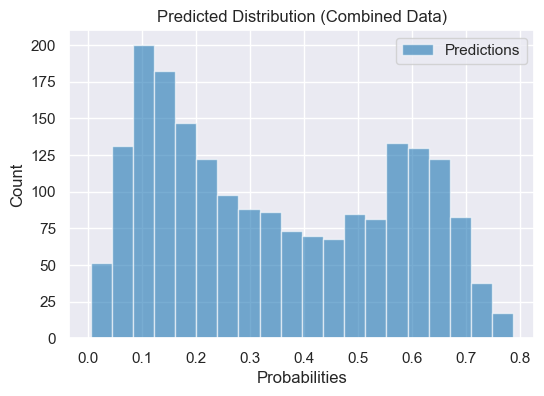

In [79]:
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
def soft_voting_predictions(X, epochs, weights, model):
    preds = np.zeros((X.shape[0], 1))
    for epoch, weight in zip(epochs, weights):
        if epoch == 1:
            epoch = '01'
        weights_path = f"./checkpoints_classifier_379_params/weights_epoch_{epoch}.h5"
        model.load_weights(weights_path)
        predictions = model.predict(X)
        preds += weight * predictions

    preds /= np.sum(weights)
    return preds

def plot_histograms(bin_centers, hist, label, title, bin_centers_labels=None, hist_labels=None):
    bar_width = bin_centers[1] - bin_centers[0]
    plt.bar(bin_centers, hist, width=bar_width, alpha=0.6, color='tab:blue', label=label)
    #if bin_centers_labels is not None and hist_labels is not None:
        #bar_width_labels = bin_centers_labels[1] - bin_centers_labels[0]
        #plt.bar(bin_centers_labels, hist_labels, width=bar_width_labels, alpha=0.3, color='red', label='Ground truth')
    plt.title(title)
    plt.xlabel('Probabilities')
    plt.ylabel('Count')
    plt.legend()

def create_and_plot_histograms(X, y, epochs, weights, model, title):
    # Compute soft voting predictions
    preds = soft_voting_predictions(X, epochs, weights, model)

    # Calculate bin edges and centers
    no_of_bins = 20  # Adjust as needed
    hist_predictions, bin_edges_unknown = np.histogram(preds, bins=no_of_bins)
    bar_width_unknown = bin_edges_unknown[1] - bin_edges_unknown[0]
    bin_centers_unknown = bin_edges_unknown[:-1] + bar_width_unknown / 2

    #hist_labels, bin_edges_labels_known = np.histogram(y, bins=no_of_bins)
    #bar_width_labels_known = bin_edges_labels_known[1] - bin_edges_labels_known[0]
    #bin_centers_labels_known = bin_edges_labels_known[:-1] + bar_width_labels_known / 2

    # Create and plot histograms
    plt.figure(figsize=(6, 4))
    plot_histograms(bin_centers_unknown, hist_predictions, 'Predictions', title)
    plt.show()

# Create and plot histograms for each dataset
create_and_plot_histograms(X_train, y_train, [40,41], [0.1,0.9], standard_nn_classifier, 'Predicted Distribution (Training Data)')
create_and_plot_histograms(X_val, y_val, [40,41], [0.1,0.9], standard_nn_classifier, 'Predicted Distribution (Validation Data)')
create_and_plot_histograms(X_test, y_test, [40,41], [0.1,0.9], standard_nn_classifier, 'Predicted Distribution (Test Data)')
create_and_plot_histograms(bcu_samples, None, [40,41], [0.1,0.9], standard_nn_classifier, 'Predicted Distribution (BCU data)')

combined_X = np.vstack((X_train, X_val, X_test))
create_and_plot_histograms(combined_X, np.concatenate((y_train, y_val, y_test)), epochs, weights, standard_nn_classifier, 'Predicted Distribution (Combined Data)')


### BCU prediction counts

In [80]:
bcu_predictions = np.squeeze(np.round(soft_voting_predictions(bcu_samples, [40,41], [0.1,0.9], standard_nn_classifier)))
print('BLLs:',len(bcu_predictions[bcu_predictions==0]))
print('FSRQs',len(bcu_predictions[bcu_predictions==1]))

BLLs: 820
FSRQs 295


### Agarwal model

In [89]:
agarwal_model=tf.keras.Sequential()
agarwal_model.add(tf.keras.Input(shape=(7,), name='Input-Layer'))
agarwal_model.add(tf.keras.layers.Dense(64, activation='relu', name='Hidden-Layer-1'))
agarwal_model.add(tf.keras.layers.Dropout(0.5))
agarwal_model.add(tf.keras.layers.Dense(32, activation='relu', name='Hidden-Layer-2'))
agarwal_model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='Output-Layer'))

agarwal_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden-Layer-1 (Dense)       (None, 64)                512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
Hidden-Layer-2 (Dense)       (None, 32)                2080      
_________________________________________________________________
Output-Layer (Dense)         (None, 1)                 33        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


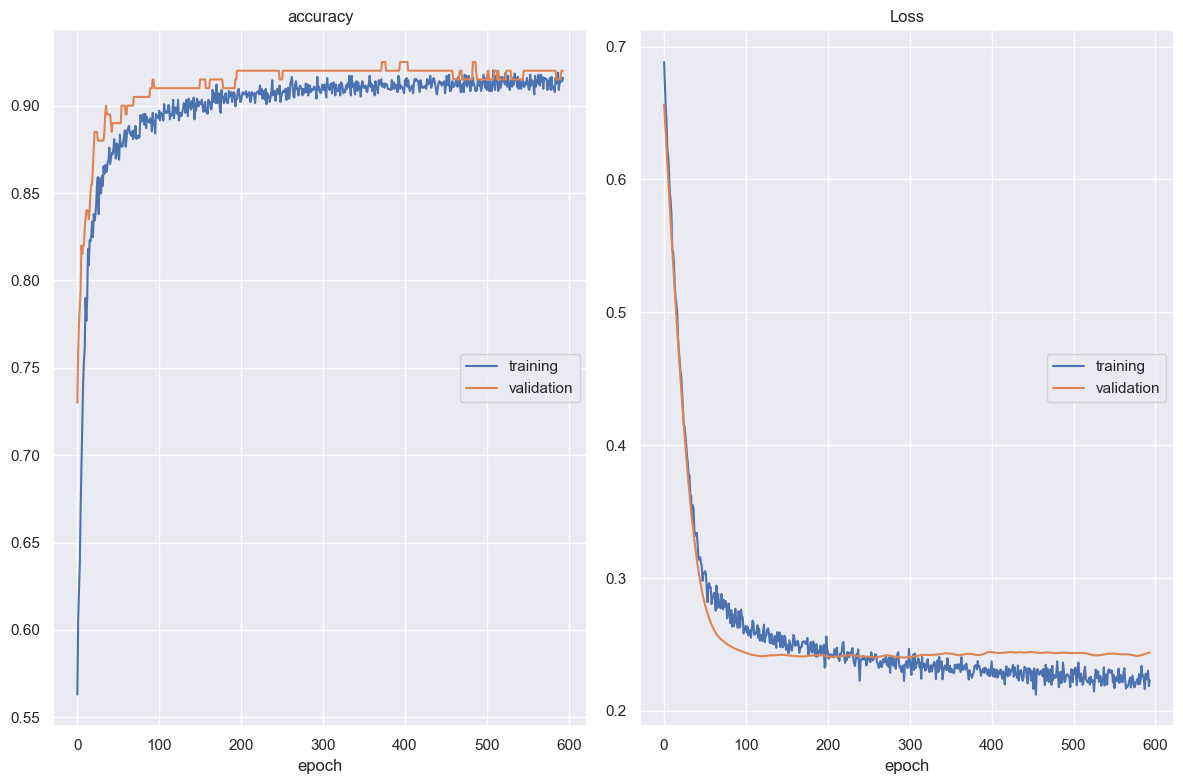

accuracy
	training         	 (min:    0.563, max:    0.920, cur:    0.916)
	validation       	 (min:    0.730, max:    0.925, cur:    0.920)
Loss
	training         	 (min:    0.212, max:    0.688, cur:    0.223)
	validation       	 (min:    0.240, max:    0.657, cur:    0.244)

Epoch 00594: saving model to ./checkpoints_classifier_agarwal\weights_epoch_594.h5


In [83]:
train_with_cw(
    model = agarwal_model,
    mode = 'classifier_agarwal',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs= 2500,
    cw=cw
)

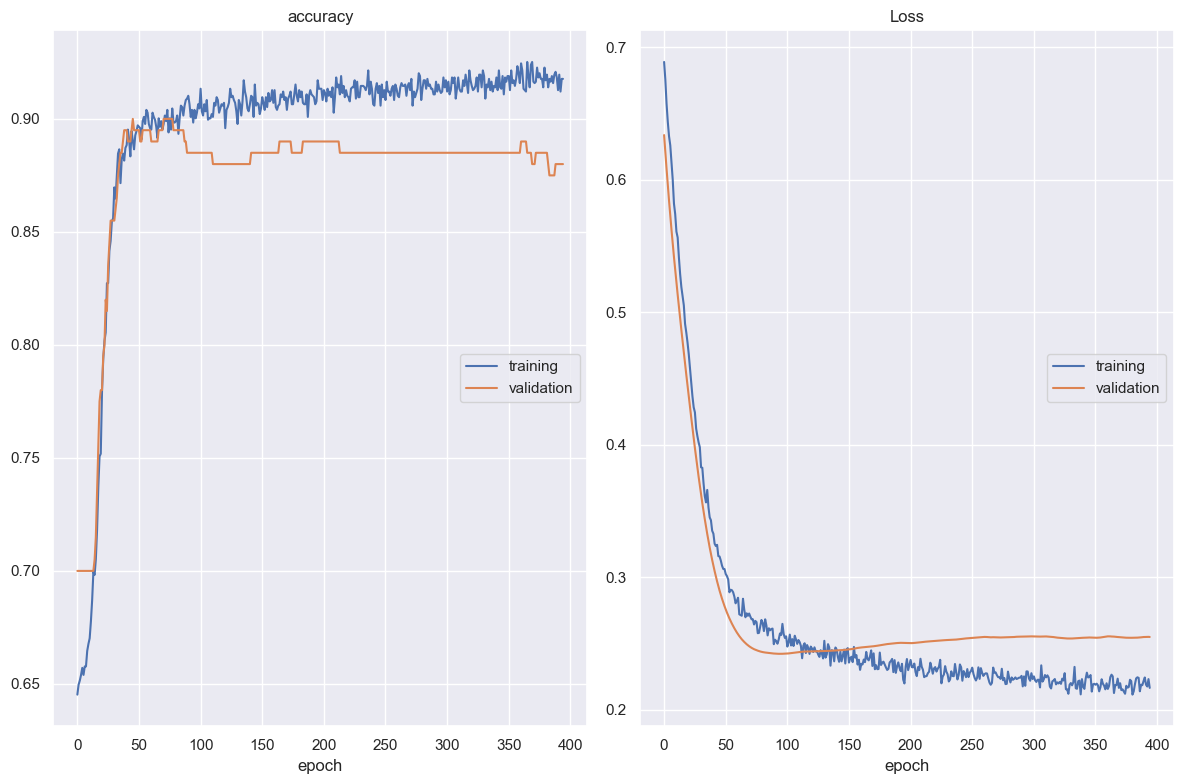

accuracy
	training         	 (min:    0.645, max:    0.925, cur:    0.918)
	validation       	 (min:    0.700, max:    0.900, cur:    0.880)
Loss
	training         	 (min:    0.211, max:    0.689, cur:    0.216)
	validation       	 (min:    0.242, max:    0.634, cur:    0.255)

Epoch 00395: saving model to ./checkpoints_classifier_agarwal_bias_init\weights_epoch_395.h5


In [87]:
train(
    model = agarwal_model,
    mode = 'classifier_agarwal_bias_init',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs= 2500
)

### Random seeds

In [106]:
import random

# Set a seed for reproducibility if needed
random.seed(42)

# Generate 10 different random seeds between 0 and 100 without repetition
random_seeds = random.sample(range(101), 10)

print("Random Seeds:", random_seeds)

Random Seeds: [81, 14, 3, 94, 35, 31, 28, 17, 13, 86]


In [107]:
def get_seeded_classifier(seed  = None):
    output_bias = tf.keras.initializers.Constant(np.log([fsrq/bll]))
    standard_nn_classifier = tf.keras.models.Sequential([
            tf.keras.layers.Dense(42, activation='relu', input_shape = (X_train.shape[1],)),
            tf.keras.layers.Dropout(0.5, seed=seed),
            tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer = output_bias)
        ])
    return standard_nn_classifier
    


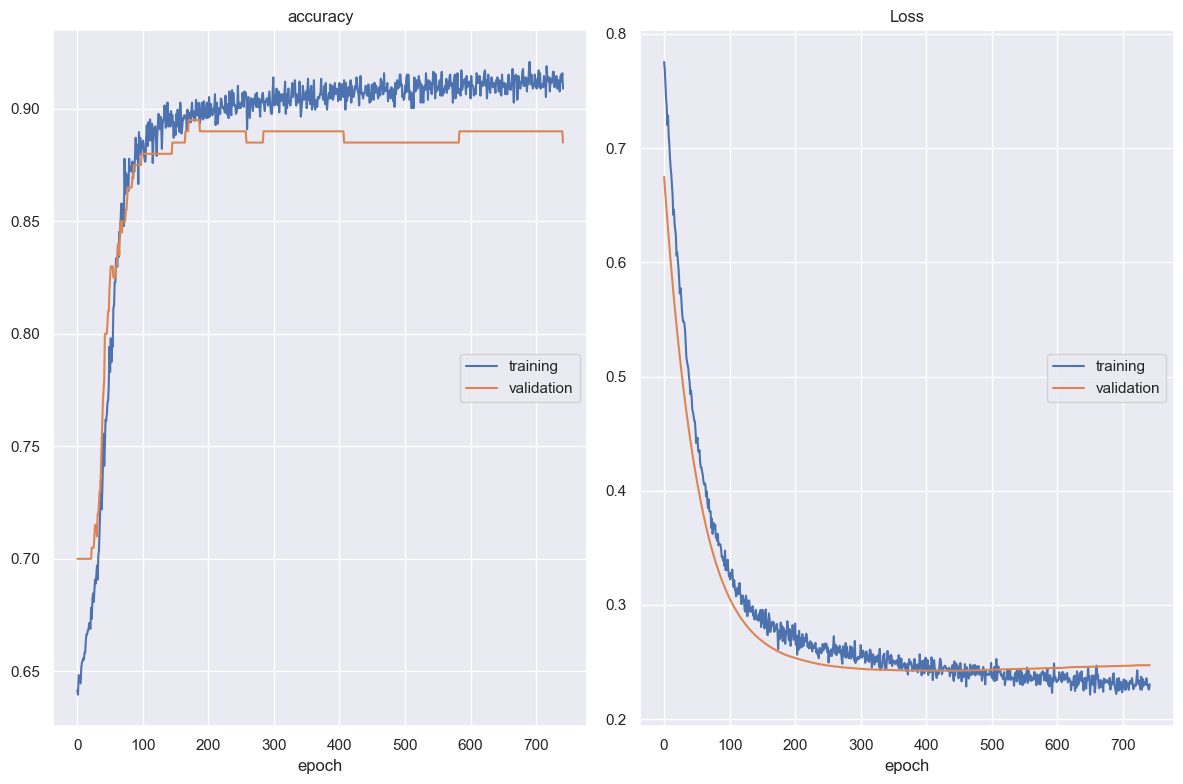

accuracy
	training         	 (min:    0.640, max:    0.921, cur:    0.909)
	validation       	 (min:    0.700, max:    0.895, cur:    0.885)
Loss
	training         	 (min:    0.221, max:    0.775, cur:    0.231)
	validation       	 (min:    0.242, max:    0.675, cur:    0.247)

Epoch 00742: saving model to ./checkpoints_classifier_seed_86\weights_epoch_742.h5


In [108]:
for seed in random_seeds:
    model = get_seeded_classifier(seed = seed)
    train(
        model = model,
        mode = f'classifier_seed_{seed}',
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs= 2500
    )

In [123]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm

def get_metric_values(folder = None, seed =  None):
    weights = os.listdir(folder)
    best_auc = []
    best_accuracy = []
    best_f1 = []
    best_f1_0 = []
    best_f1_1 = []
    best_precision = []
    best_pr_0 = []
    best_pr_1 = []
    best_r0 = []
    best_r1 = []
    best_recall = []
    for weight in weights:
        weight_file = folder + f'/{weight}'
        model = get_seeded_classifier(seed = seed)
        model.load_weights(weight_file)
        predictions = model.predict(X_test)
        roc_auc = roc_auc_score(y_test, predictions)
        accuracy = accuracy_score(y_test, np.round(predictions))
        f1_0 = f1_score(y_test, np.round(predictions), pos_label=0)
        f1_1 = f1_score(y_test, np.round(predictions), pos_label=1)
        f1 = f1_score(y_test, np.round(predictions), average='weighted')
        precision = precision_score(y_test, np.round(predictions), average='weighted')
        pr_0 = precision_score(y_test, np.round(predictions), pos_label=0)
        pr_1 = precision_score(y_test, np.round(predictions), pos_label=1)
        r0 = recall_score(y_test, np.round(predictions), pos_label=0)
        r1 = recall_score(y_test, np.round(predictions), pos_label=1)
        recall = recall_score(y_test, np.round(predictions), average='weighted')
        best_auc.append(roc_auc)
        best_accuracy.append(accuracy)
        best_f1_0.append(f1_0)
        best_f1_1.append(f1_1)
        best_f1.append(f1)
        best_precision.append(precision)
        best_pr_0.append(pr_0)
        best_pr_1.append(pr_1)
        best_r0.append(r0)
        best_r1.append(r1)
        best_recall.append(recall)
    
    return np.max(best_auc), np.max(best_accuracy), np.max(best_f1_0), np.max(best_f1_1), np.max(best_f1), np.max(best_pr_0), np.max(best_pr_1), np.max(best_precision), np.max(best_r0), np.max(best_r1), np.max(best_recall)

auc = []
accuracy = []
f1_0 = []
f1_1 = []
f1 = []
pr_0 = []
pr_1 = []
pr = []
r0 = []
r1 = []
r = []
for seed in tqdm(random_seeds):
    folder = f'./checkpoints_classifier_seed_{seed}'
    values = get_metric_values(folder=folder, seed = seed)
    auc.append(values[0])
    accuracy.append(values[1])
    f1_0.append(values[2])
    f1_1.append(values[3])
    f1.append(values[4])
    pr_0.append(values[5])
    pr_1.append(values[6])
    pr.append(values[7])
    r0.append(values[8])
    r1.append(values[9])
    r.append(values[10])


    

 30%|███       | 3/10 [02:44<06:17, 53.87s/it]c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abhim\anaconda3\e

In [124]:
print(f"AUC:{np.mean(auc)} \u00B1 {np.std(auc)}")
print(f"Accuracy:{np.mean(accuracy)} \u00B1 {np.std(accuracy)}")
print(f"F1(0):{np.mean(f1_0)} \u00B1 {np.std(f1_0)}")
print(f"F1(1):{np.mean(f1_1)} \u00B1 {np.std(f1_1)}")
print(f"F1:{np.mean(f1)} \u00B1 {np.std(f1)}")
print(f"PR(0):{np.mean(pr_0)} \u00B1 {np.std(pr_0)}")
print(f"PR(1):{np.mean(pr_1)} \u00B1 {np.std(pr_1)}")
print(f"PR:{np.mean(pr)} \u00B1 {np.std(pr)}")
print(f"R(0):{np.mean(r0)} \u00B1 {np.std(r0)}")
print(f"R(1):{np.mean(r1)} \u00B1 {np.std(r1)}")
print(f"R:{np.mean(r)} \u00B1 {np.std(r)}")

AUC:0.9572929100023874 ± 0.0006333969520850562
Accuracy:0.9184079601990052 ± 0.004559776810901313
F1(0):0.9423451639531351 ± 0.003641608177495907
F1(1):0.8613270464296334 ± 0.006206664452442287
F1:0.9184576953241651 ± 0.004285829025305091
PR(0):0.943422235540905 ± 0.00019574386117532944
PR(1):0.9276181980374666 ± 0.06492293381606454
PR:0.9186627610372196 ± 0.004316928444913999
R(0):0.9753521126760564 ± 0.02464788732394367
R(1):0.8661016949152543 ± 0.005084745762711851
R:0.9184079601990052 ± 0.004559776810901313


### Inference

In [89]:
print("Warming up...")

_ = agarwal_model.predict(X_test)

print("Done warming up!")

Warming up...
Done warming up!


In [99]:
%%timeit

_ = agarwal_model.predict(X_test)

40.5 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
print("Warming up...")

standard_nn_classifier.load_weights('./checkpoints_classifier_379_params/weights_epoch_41.h5')
_ = standard_nn_classifier.predict(X_test)


print("Done warming up!")

Warming up...
Done warming up!


In [83]:
%%timeit

_ = standard_nn_classifier.predict(X_test)

36.4 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [84]:
X_test.shape[0]

201